In [1]:
import splitfolders
input_folder=r'C:\Users\vamsi\VAMSI\4-2\Project\DataSet\flowers'
splitfolders.ratio(input_folder,output='flowers2',seed=42,ratio=(.8,.1,.1),group_prefix=None)

Copying files: 4316 files [02:04, 34.68 files/s]


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
"""from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
"""

Mounted at /gdrive
/gdrive


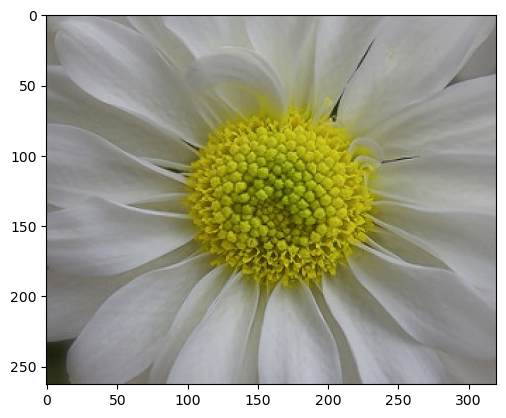

In [4]:
train_dir= r"C:\Users\vamsi\VAMSI\4-2\Project\MAIN PROJECT\flowers2\train"
test_dir= r"C:\Users\vamsi\VAMSI\4-2\Project\MAIN PROJECT\flowers2\test"
val_dir= r"C:\Users\vamsi\VAMSI\4-2\Project\MAIN PROJECT\flowers2\val"

#visulaization of image
flower_name=os.listdir(train_dir)[0]
flower_path=os.path.join(train_dir,flower_name)
img_name=os.listdir(flower_path)[0]
image_path=os.path.join(flower_path,img_name)
img=mpimg.imread(image_path)
plt.imshow(img)
plt.show()

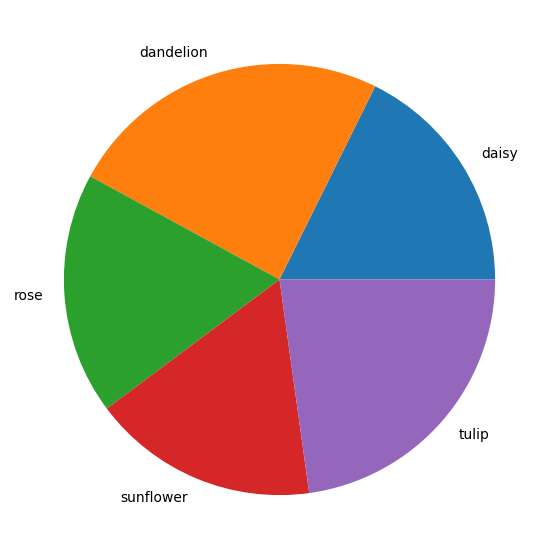

In [3]:
classes=['daisy','dandelion','rose','sunflower','tulip']
classa=r'C:\Users\vamsi\VAMSI\4-2\Project\DataSet\flowers\daisy'
classb=r'C:\Users\vamsi\VAMSI\4-2\Project\DataSet\flowers\dandelion'
classc=r'C:\Users\vamsi\VAMSI\4-2\Project\DataSet\flowers\rose'
classd=r'C:\Users\vamsi\VAMSI\4-2\Project\DataSet\flowers\sunflower'
classe=r'C:\Users\vamsi\VAMSI\4-2\Project\DataSet\flowers\tulip'
classa_size=len(os.listdir(classa))
classb_size=len(os.listdir(classb))
classc_size=len(os.listdir(classc))
classd_size=len(os.listdir(classd))
classe_size=len(os.listdir(classe))
data = [classa_size, classb_size,classc_size,classd_size,classe_size]
 
# Creating plot
fig = plt.figure(figsize =(10, 7))
plt.pie(data, labels = classes)
 
# show plot
plt.show()

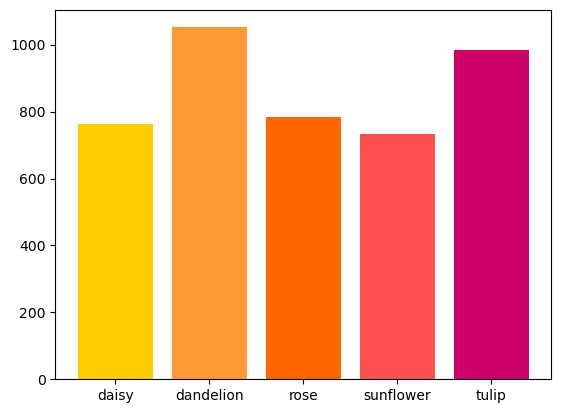

In [4]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array(classes)
y = np.array(data)
color=['#ffcc00','#ff9933','#ff6600','#ff5050','#cc0066']
plt.bar(x,y,color=color)
plt.show()

In [5]:
import random
import numpy as np


class CutMixImageDataGenerator():
    def __init__(self, generator1, generator2, img_size, batch_size):
        self.batch_index = 0
        self.samples = generator1.samples
        self.class_indices = generator1.class_indices
        self.generator1 = generator1
        self.generator2 = generator2
        self.img_size = img_size
        self.batch_size = batch_size

    def reset_index(self):  # Ordering Reset (If Shuffle is True, Shuffle Again)
        self.generator1._set_index_array()
        self.generator2._set_index_array()

    def reset(self):
        self.batch_index = 0
        self.generator1.reset()
        self.generator2.reset()
        self.reset_index()

    def get_steps_per_epoch(self):
        quotient, remainder = divmod(self.samples, self.batch_size)
        return (quotient + 1) if remainder else quotient
    
    def __len__(self):
        self.get_steps_per_epoch()

    def __next__(self):
        if self.batch_index == 0: self.reset()

        crt_idx = self.batch_index * self.batch_size
        if self.samples > crt_idx + self.batch_size:
            self.batch_index += 1
        else:  # If current index over number of samples
            self.batch_index = 0

        reshape_size = self.batch_size
        last_step_start_idx = (self.get_steps_per_epoch()-1) * self.batch_size
        if crt_idx == last_step_start_idx:
            reshape_size = self.samples - last_step_start_idx
            
        X_1, y_1 = self.generator1.next()
        X_2, y_2 = self.generator2.next()
        
        cut_ratio = np.random.beta(a=1, b=1, size=reshape_size)
        cut_ratio = np.clip(cut_ratio, 0.2, 0.8)
        label_ratio = cut_ratio.reshape(reshape_size, 1)
        cut_img = X_2

        X = X_1
        for i in range(reshape_size):
            cut_size = int((self.img_size-1) * cut_ratio[i])
            y1 = random.randint(0, (self.img_size-1) - cut_size)
            x1 = random.randint(0, (self.img_size-1) - cut_size)
            y2 = y1 + cut_size
            x2 = x1 + cut_size
            cut_arr = cut_img[i][y1:y2, x1:x2]
            cutmix_img = X_1[i]
            cutmix_img[y1:y2, x1:x2] = cut_arr
            X[i] = cutmix_img
            
        y = y_1 * (1 - (label_ratio ** 2)) + y_2 * (label_ratio ** 2)
        return X, y

    def __iter__(self):
        while True:
            yield next(self)

In [20]:

train_datagen=ImageDataGenerator(

    rescale=1./255,
    rotation_range=40,  
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
test_datagen=ImageDataGenerator(rescale=1./255)


print("train data")
train_generator1=train_datagen.flow_from_directory(
train_dir,
target_size=(224,224),
batch_size=11,
class_mode='categorical')

train_generator2=train_datagen.flow_from_directory(
train_dir,
target_size=(224,224),
batch_size=11,
class_mode='categorical')

train_generator=CutMixImageDataGenerator(
train_generator1,
train_generator2,
img_size=224,
batch_size=11,)



print("validation data")
val_generator=train_datagen.flow_from_directory(
val_dir,
target_size=(224,224),
batch_size=28,
class_mode='categorical')

print("test data")
test_generator=test_datagen.flow_from_directory(
test_dir,
target_size=(224,224),
batch_size=26,
class_mode='categorical')

train data
Found 4250 images belonging to 5 classes.
Found 4250 images belonging to 5 classes.
validation data
Found 2130 images belonging to 5 classes.
test data
Found 1214 images belonging to 5 classes.


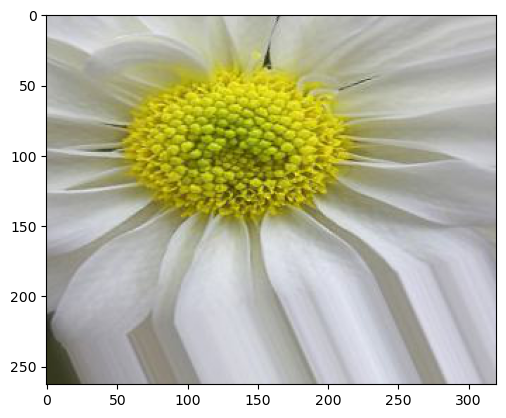

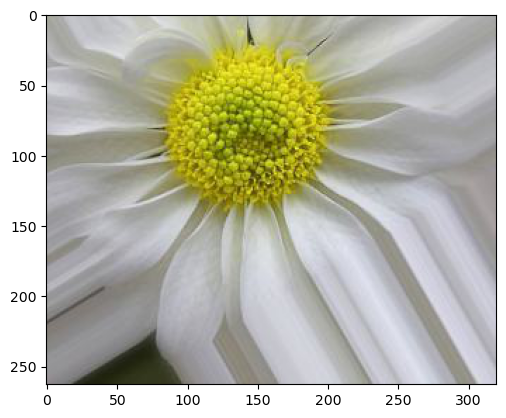

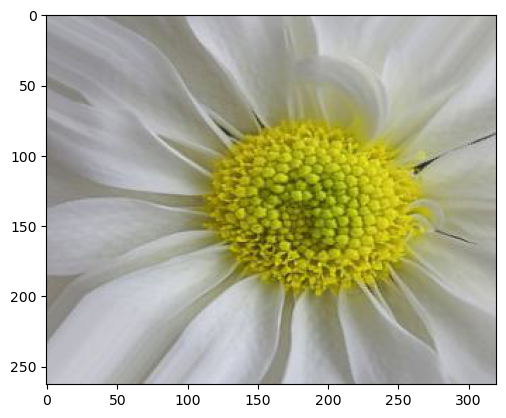

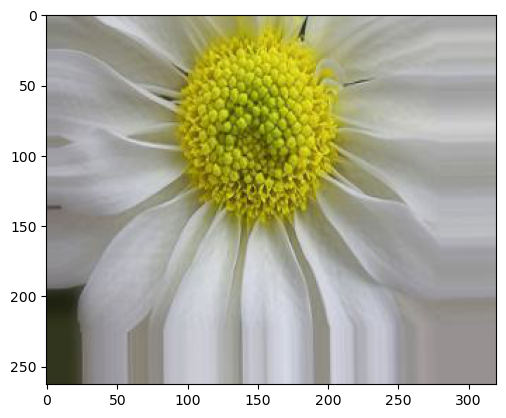

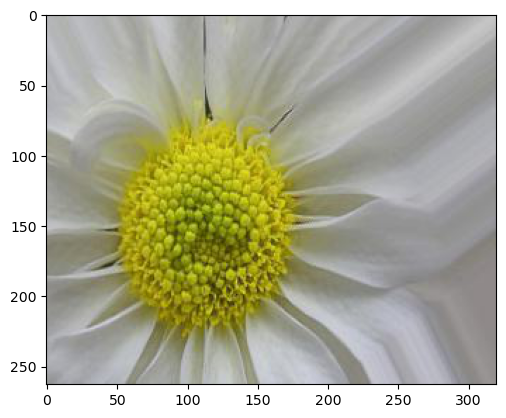

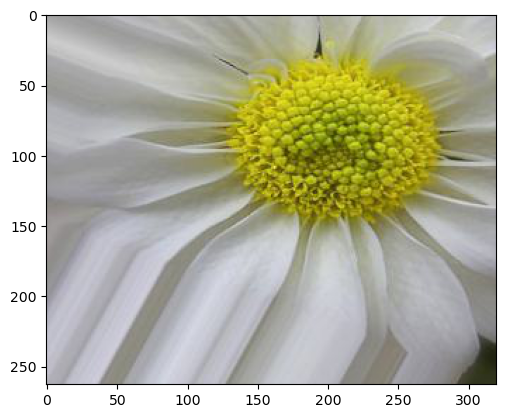

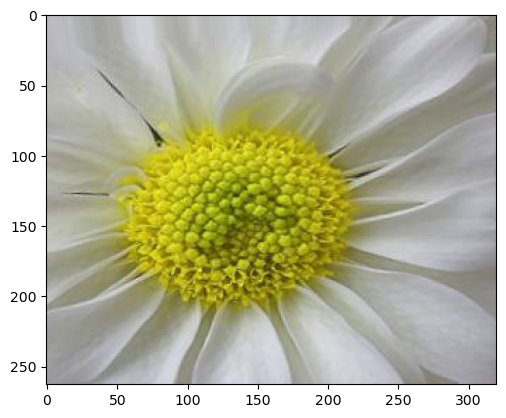

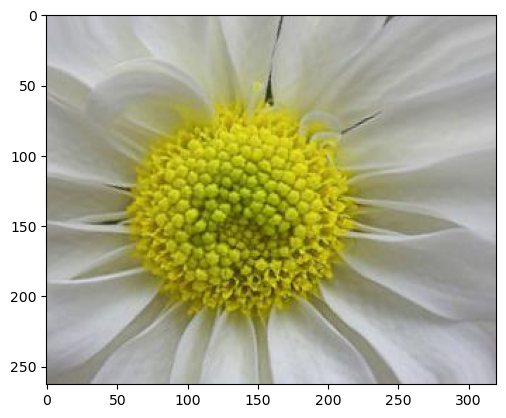

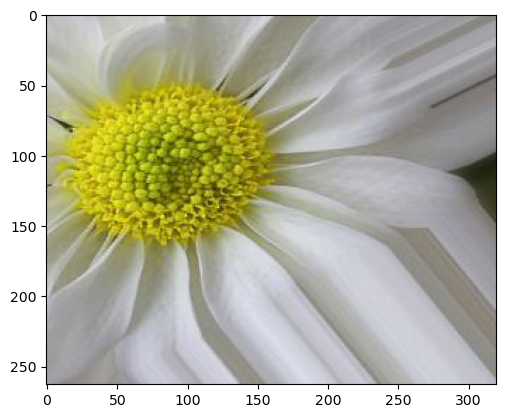

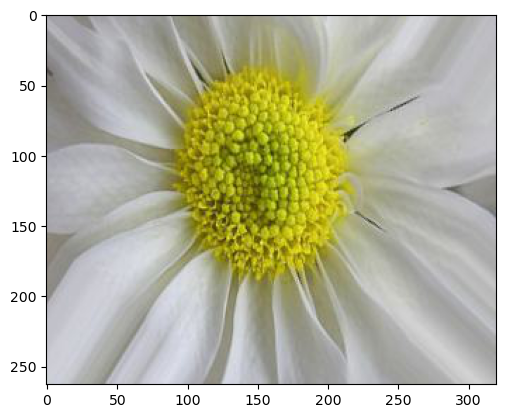

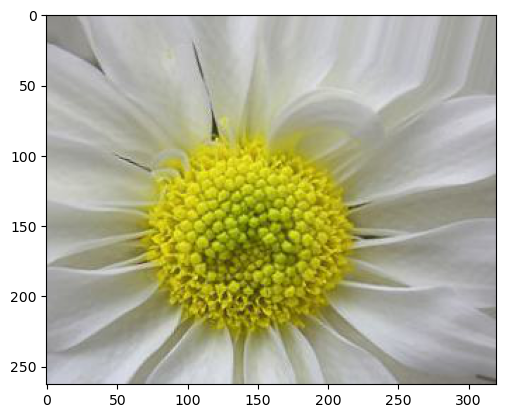

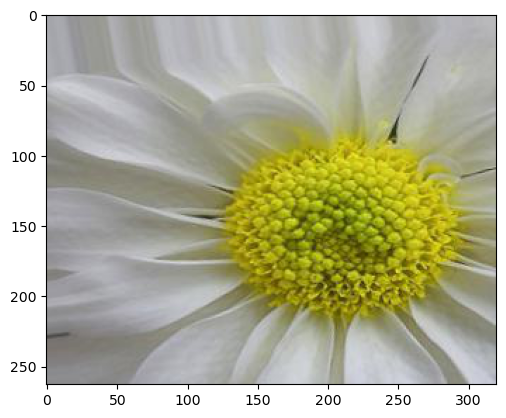

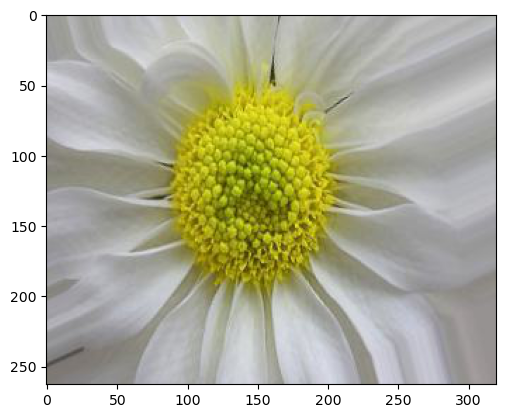

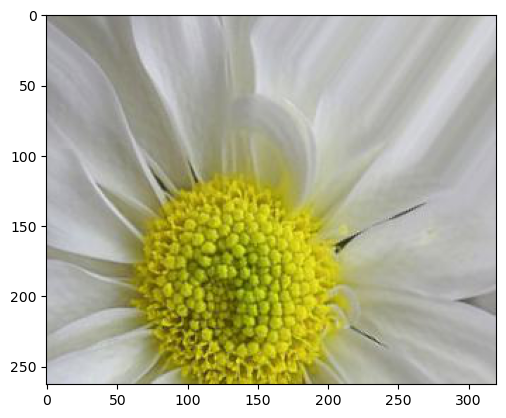

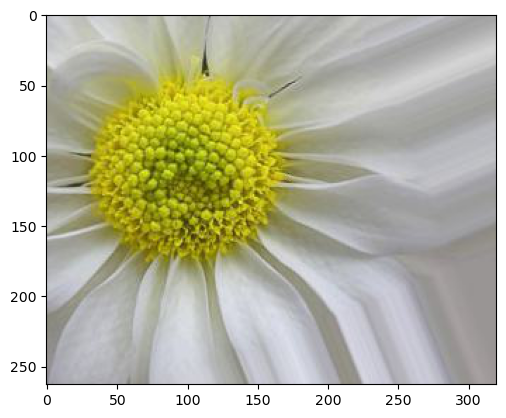

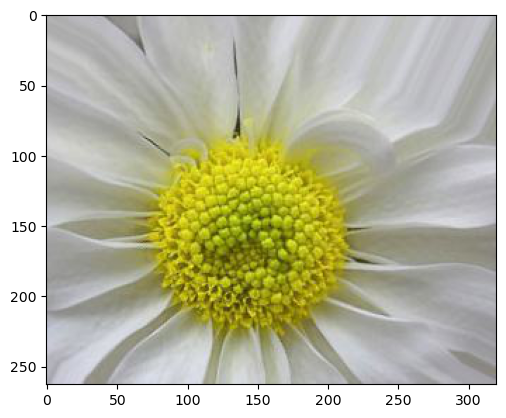

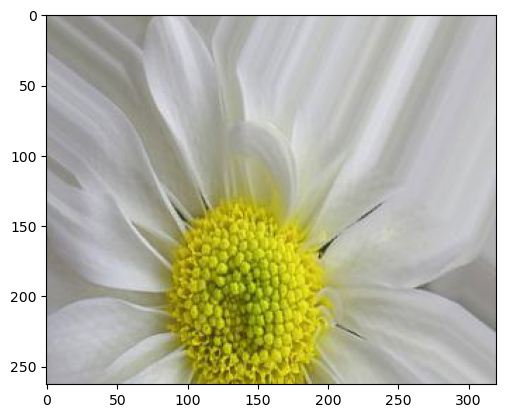

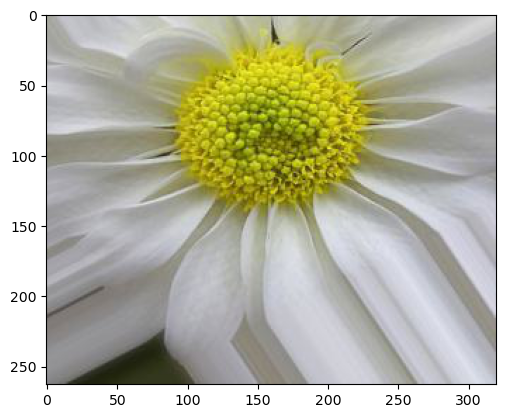

In [7]:
#visualization of preprocessing

pic=load_img(image_path)
pic_array=img_to_array(pic)
pic_array=pic_array.reshape((1,)+pic_array.shape)
count=0
output=r"C:\Users\vamsi\VAMSI\4-2\Project\MAIN PROJECT\preprocessvisualize"
for batch in train_datagen.flow(pic_array, batch_size=1,save_to_dir=output, save_prefix='flower', save_format='jpeg'):
    count+=1
    if count>10:
        break;
    
    
for im in os.listdir(output):
    im_path=os.path.join(output,im)
    im=mpimg.imread(im_path)
    plt.imshow(im)
    plt.show()
    

In [7]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.applications import Xception
model=models.Sequential()
conv_base=Xception(weights='imagenet',include_top=False,input_shape=(224,224,3))
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(5,activation='softmax'))

83683744/83683744 [==============================] - 1s 0us/step


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 512)               51380736  
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 72,244,781
Trainable params: 72,190,253
Non-trainable params: 54,528
_________________________________________________________________


In [9]:
from tensorflow.keras import optimizers
model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(learning_rate=0.0001),metrics=['acc'])

In [11]:
from keras.callbacks import ModelCheckpoint
filepath='/best_model.epoch{epoch:02d}-acc{val_acc:.2f}.h5'
checkpoint1=ModelCheckpoint(filepath=filepath,monitor='val_acc',verbose=1,save_best_only=True,mode='max')
filepath='/best_model.epoch{epoch:02d}-loss{val_loss:.2f}.h5'
checkpoint2=ModelCheckpoint(filepath=filepath,monitor='val_loss',verbose=1,save_best_only=True,mode='min')
callbacks=[checkpoint1,checkpoint2]
history=model.fit(
train_generator,
epochs=25,
steps_per_epoch=train_generator.get_steps_per_epoch(),
validation_data=val_generator, 
validation_steps=76,
callbacks=callbacks)

Epoch 1/25
387/387 [==============================] - ETA: 0s - loss: 1.0230 - acc: 0.7129
Epoch 1: val_acc improved from -inf to 0.90977, saving model to /best_model.epoch01-acc0.91.h5

Epoch 1: val_loss improved from inf to 0.31902, saving model to /best_model.epoch01-loss0.32.h5
387/387 [==============================] - 1131s 3s/step - loss: 1.0230 - acc: 0.7129 - val_loss: 0.3190 - val_acc: 0.9098
Epoch 2/25
387/387 [==============================] - ETA: 0s - loss: 0.9073 - acc: 0.7626
Epoch 2: val_acc improved from 0.90977 to 0.92152, saving model to /best_model.epoch02-acc0.92.h5

Epoch 2: val_loss improved from 0.31902 to 0.26595, saving model to /best_model.epoch02-loss0.27.h5
387/387 [==============================] - 215s 557ms/step - loss: 0.9073 - acc: 0.7626 - val_loss: 0.2659 - val_acc: 0.9215
Epoch 3/25
387/387 [==============================] - ETA: 0s - loss: 0.8491 - acc: 0.8054
Epoch 3: val_acc improved from 0.92152 to 0.94173, saving model to /best_model.epoch03-a

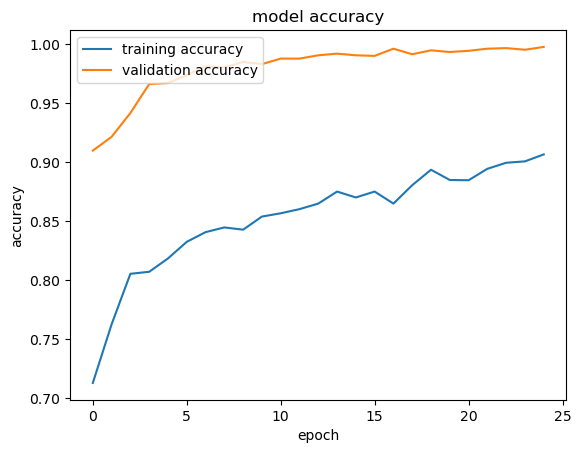

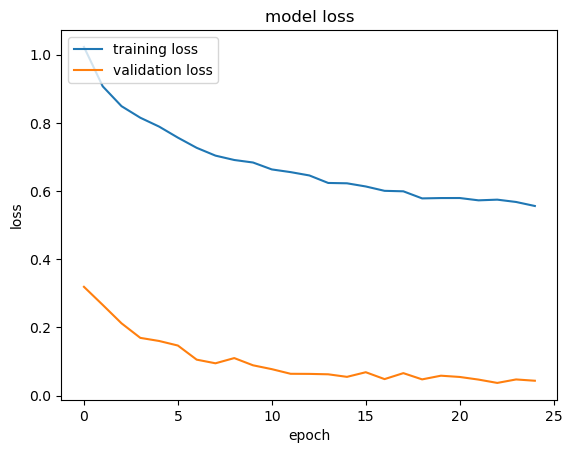

In [17]:
x=np.arange(1,26)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy', 'validation accuracy'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training loss', 'validation loss'], loc='upper left')
plt.show()

In [14]:
new_model = tf.keras.models.load_model('/gdrive/MyDrive/best_model.epoch25-acc1.00.h5')
results = new_model.evaluate(test_generator, batch_size=32)
tf.print('Accuracy: ', results[1]*100)

47/47 [==============================] - 251s 5s/step - loss: 0.0440 - acc: 0.9975
Accuracy:  99.75288510322571


In [27]:
results

[0.04402580112218857, 0.9975288510322571]
